# Определение возраста покупателей

В этом проекте у нас стоит задача внедрить систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [24]:
labels.info()
labels.head()
labels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В нашем датасете находится 7591 объект,а именно пары: название фотграфии - возраст. Пропуски отсутствуют, рассмотрим распределение возраста 

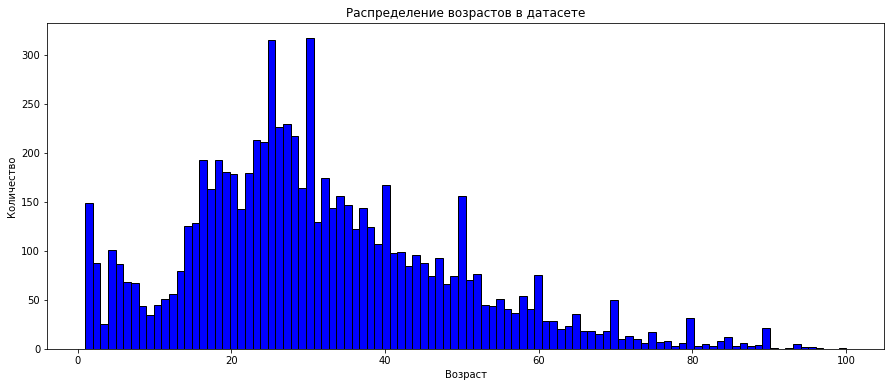

In [13]:
fig = plt.figure(figsize=(15, 6))
plt.hist(labels['real_age'],color = 'blue', edgecolor = 'black',
         bins = labels['real_age'].max())
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возрастов в датасете')
plt.show()

Как видим, основная часть датасета расположена в возрасте от 15 до 50, такое распредление данных, поможет ответить нам на обе поставленные бизнесом задачи.

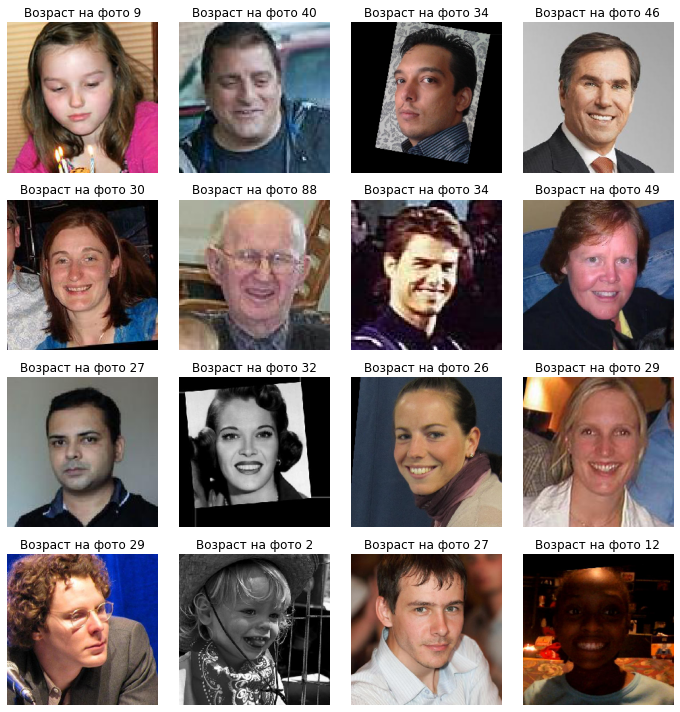

In [23]:
features, target = train_gen_flow.next()
fig = plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Возраст на фото {}'.format(target[i]))
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Как видим, генератор работает исправно, данные размечены корректно, у нас нет 85 летних детей, и наоборот

Наш объем данных, с которыми мы работаем - 7591. Основной возраст в нашем датасете - от 15 до 50, такой датасет и по объему, и по распределению возраста будет хорошо подходить нам для наших задач. В случае, если данных окажется недостаточно, мы сможем применить аугментацию к данным, что расширит наш датасет

## Обучение модели

```python


from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50


def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    directory = path + '/final_files'
    datagen_train = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.25
                                       )
    train_datagen_flow = datagen_train.flow_from_dataframe(dataframe=labels,
                                                           directory=directory,
                                                           target_size=(150, 150),
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           shuffle=True,
                                                           seed=12345,
                                                           subset='training')

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    images_path = path + '/final_files'

    datagen_test = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.25
                                      )
    test_datagen_flow = datagen_test.flow_from_dataframe(
        dataframe=labels,
        directory=images_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode='raw',
        batch_size=16,
        shuffle=True,
        seed=12345,
        subset='validation'
    )

    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(150, 150, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```


Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 50s - loss: 196.8040 - mae: 10.3977 - val_loss: 581.0838 - val_mae: 19.0575
Epoch 2/5
356/356 - 41s - loss: 62.9106 - mae: 6.0671 - val_loss: 155.3706 - val_mae: 9.5059
Epoch 3/5
356/356 - 42s - loss: 31.9064 - mae: 4.3402 - val_loss: 99.6047 - val_mae: 7.9600
Epoch 4/5
356/356 - 40s - loss: 18.2161 - mae: 3.2428 - val_loss: 77.9727 - val_mae: 6.8240
Epoch 5/5
356/356 - 42s - loss: 12.8456 - mae: 2.6943 - val_loss: 70.9107 - val_mae: 6.3964
119/119 - 10s - loss: 70.9107 - mae: 6.3964
Test MAE: 6.3964

```

## Анализ обученной модели

Построили модель с использованием ResNet50, время обучения состовляет меньше 4,5 минуты. Добились требуемого значения метрики < 7. Не стали применять аугментации к данным, т.к. модель сильно переобучалась в таком случае.
Тот факт, что мы добились значения метрики `MAE` меньше 7, означает для нас следующее:
- Не совсем корректно использовать данную модель для контролированния добросовестности кассиров, т.к. разность в 7 лет будет существенна для продажи алкоголя - делая её в некоторых ситуациях нелегальной
- Вполне применима для того, что бы определять возрастные группы
